In [2]:
import importlib
import time
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import integrate
from scipy import interpolate
import os
import pickle

In [3]:
from multi_loc import covariance, assimilate, utilities

In [4]:
%matplotlib inline
def imshow(X, title=None, vmin=None, vmax=None, cmap=None):
    plt.figure()
    im = plt.imshow(X, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(im)
    plt.title(title)

In [5]:
N_Z = 2**9
print(N_Z)
rho0_l = 0.2
rho0_s = 0.002
# rho0 = 0.2
# dx = 0.25
dz = 1/N_Z

z = np.arange(N_Z)

# obs_size = int(dimension/2)
# H = assimilate.random_H(dimension, obs_size)

H_Z = np.eye(N_Z)[::2]
N_Y = H_Z.shape[0]
y = H_Z @ z

rho = np.arange(N_Z, dtype=float)
rho = np.minimum(rho, (N_Z - rho) % N_Z)
rho = rho*dz

512


In [6]:
coarse = 8
N_X = N_Z // coarse
dx = dz * coarse

S_ZX = np.eye(N_Z)[::coarse]
S_XZ = utilities.lin_interp_matrix(N_Z, coarse)

H_X = H_Z @ S_XZ

In [7]:
this_Z = np.sin(np.arange(N_Z)/(N_Z) * 5 * 2 * np.pi)
this_X = S_ZX @ this_Z
x = S_ZX @ z

this_Xf = S_XZ @ this_X

In [12]:
eig_val_l, eig_vec_l, P_l, sort_index = covariance.generate_circulant(
    N_Z, dz, rho0_l, covariance.fft_sqd_exp_1d,
    return_Corr=True, return_sort_ind=True)
print('long variance: ', eig_val_l.mean())
eig_val_l = eig_val_l / eig_val_l.mean()
sort_index = np.argsort(sort_index)
eig_val_l = eig_val_l[sort_index]
eig_vec_l = eig_vec_l[:, sort_index]
P_l = eig_vec_l @ np.diag(eig_val_l) @ eig_vec_l.conj().T
P_l = P_l.real

eig_val_s, eig_vec_s, P_s, sort_index = covariance.generate_circulant(
    N_Z, dz, rho0_s, covariance.fft_sqd_exp_1d,
    return_Corr=True, return_sort_ind=True)
print('short variance: ', eig_val_s.mean())
eig_val_s = eig_val_s / eig_val_s.mean()
sort_index = np.argsort(sort_index)
eig_val_s = eig_val_s[sort_index]
eig_vec_s = eig_vec_s[:, sort_index]
P_s = eig_vec_s @ np.diag(eig_val_s) @ eig_vec_s.conj().T
P_s = P_s.real
#P_s = P_s/P_s.max()

al = 0.5
eig_val = (1 - al) * eig_val_s + al * eig_val_l
eig_vec = eig_vec_l.copy()

eig_val = eig_val / eig_val.mean()

sort_index = np.argsort(eig_val)[::-1]
eig_val = eig_val[sort_index]
eig_vec = eig_vec[:, sort_index]

P = eig_vec @ np.diag(eig_val) @ eig_vec.conj().T
P = P.real

sort_index = np.argsort(eig_val_l)[::-1]
eig_val_l = eig_val_l[sort_index]
eig_vec_l = eig_vec_l[:, sort_index]

sort_index = np.argsort(eig_val_s)[::-1]
eig_val_s = eig_val_s[sort_index]
eig_vec_s = eig_vec_s[:, sort_index]

R_var = 0.1
R = R_var * np.eye(N_Y)

trans_mats_true = assimilate.transformation_matrices(
    H_Z, eig_val_p=eig_val, eig_vec_p=eig_vec,
    R=R, return_Ts=True)


trans_mats_long = assimilate.transformation_matrices(
    H_Z, eig_val_p=eig_val_l, eig_vec_p=eig_vec_l,
    R=R, return_Ts=True)


trans_mats_short = assimilate.transformation_matrices(
    H_Z, eig_val_p=eig_val_s, eig_vec_p=eig_vec_s,
    R=R, return_Ts=True)


for key, val in trans_mats_true.items():
    exec(key + '=val')
for key, val in trans_mats_long.items():
    exec(key+'_l' + '=val')
for key, val in trans_mats_short.items():
    exec(key+'_s' + '=val')

long variance:  1.000007453306344
short variance:  0.9987043816800435


Log10(condition):  4.251024079665023


Text(0.5, 0.98, 'Eigenvalues P_s')

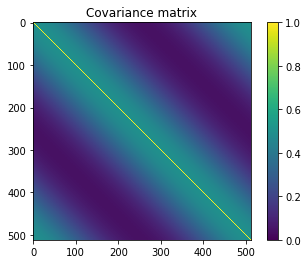

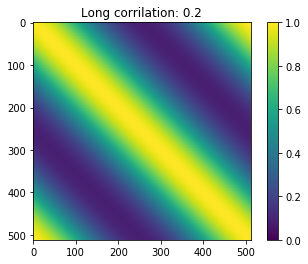

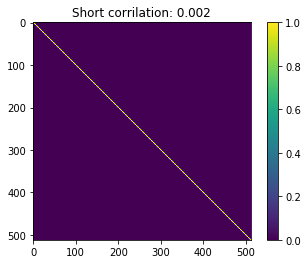

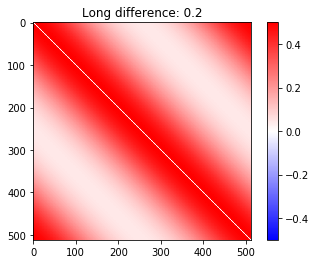

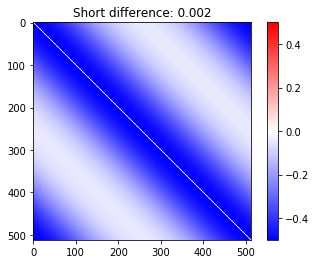

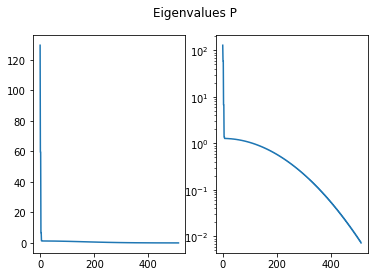

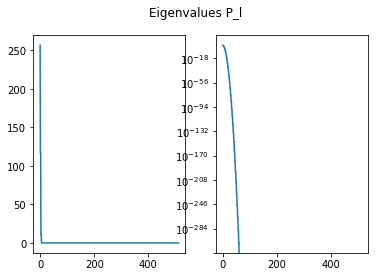

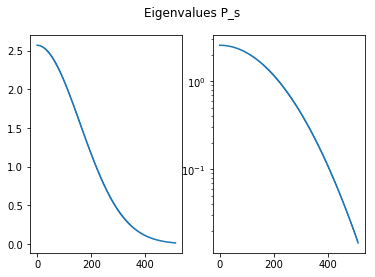

In [13]:
imshow(P, title='Covariance matrix', vmin=0, vmax=1)
imshow(P_l, title=f'Long corrilation: {rho0_l}', vmin=0, vmax=1)
imshow(P_s, title=f'Short corrilation: {rho0_s}', vmin=0, vmax=1)

error_l = P_l - P
error_s = P_s - P

vmax = np.max([np.abs(error_l).max(),
               np.abs(error_s).max()])

imshow(error_l, title=f'Long difference: {rho0_l}',
       vmin=-vmax, vmax=vmax, cmap='bwr')
imshow(error_s, title=f'Short difference: {rho0_s}',
       vmin=-vmax, vmax=vmax, cmap='bwr')
print('Log10(condition): ',
      np.log10(np.linalg.cond(P)))

fig, ax = plt.subplots(1, 2)
ax[0].plot(eig_val)
ax[1].semilogy(eig_val)
plt.suptitle('Eigenvalues P')

fig, ax = plt.subplots(1, 2)
ax[0].plot(eig_val_l)
ax[1].semilogy(eig_val_l)
plt.suptitle('Eigenvalues P_l')

fig, ax = plt.subplots(1, 2)
ax[0].plot(eig_val_s)
ax[1].semilogy(eig_val_s)
plt.suptitle('Eigenvalues P_s')

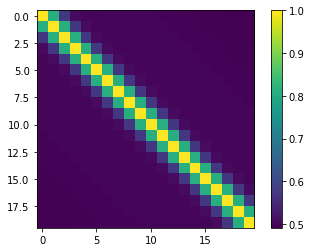

In [14]:
imshow(P[:20, :20])

In [15]:
P_z = P.copy()
P_x = P[::coarse, ::coarse]

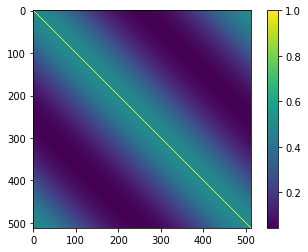

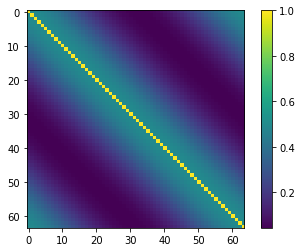

In [16]:
imshow(P_z)
imshow(P_x)

In [26]:
trans_mats_z = assimilate.transformation_matrices(
    H_Z, P=P_z,
    R=R, return_Ts=True)
trans_mats_x = assimilate.transformation_matrices(
    H_X, P=P_x,
    R=R, return_Ts=True)

for key, val in trans_mats_z.items():
    exec(key + '_z=val')
for key, val in trans_mats_x.items():
    exec(key + '_x=val')

In [17]:
importlib.reload(assimilate)

<module 'multi_loc.assimilate' from '/Users/harty/Documents/python_code/multi_loc/multi_loc/assimilate.py'>

In [89]:
N_eXc = 10000
N_eZ = 1000

mu = np.zeros(N_Z)
X = assimilate.generate_ensemble(N_eXc, mu, P_sqrt)
X = X[::coarse]
# X = ndimage.uniform_filter1d(X

Z = assimilate.generate_ensemble(N_eZ, mu, P_sqrt)

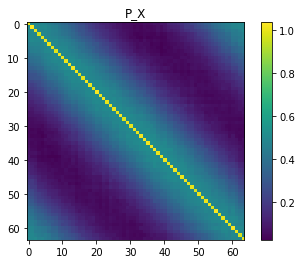

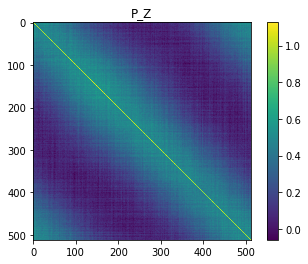

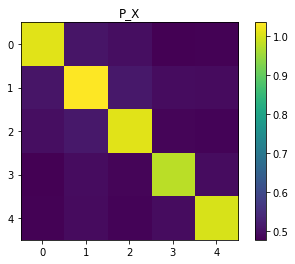

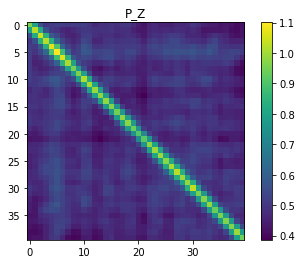

In [90]:
P_X = np.cov(X)
C_X = np.corrcoef(X)
P_Z = np.cov(Z)
C_Z = np.corrcoef(Z)

imshow(P_X, title='P_X')
imshow(P_Z, title='P_Z')

imshow(P_X[:5, :5], title='P_X')
imshow(P_Z[:int(5*coarse), :int(5*coarse)], title='P_Z')

In [91]:
Q, Lambda, temp = np.linalg.svd((X - np.mean(X, axis=1)[:, None]))
Lambda = Lambda / np.sqrt(N_eXc - 1)

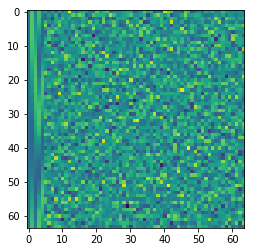

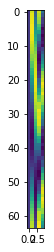

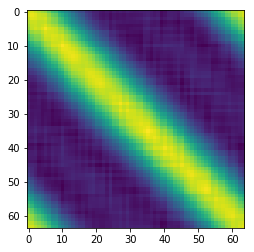

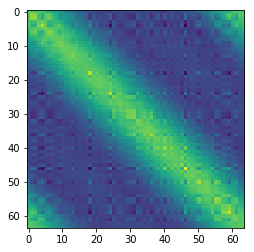

In [92]:
plt.figure()
plt.imshow(Q)

N_lx = 5

plt.figure()
plt.imshow(Q[:, :N_lx])

plt.figure()
im = plt.imshow(Q[:, :N_lx] @ np.diag(Lambda[:N_lx]) @ Q[:, :N_lx].T)

plt.figure()
im = plt.imshow(Q[:, :N_lx + 1] @ np.diag(Lambda[:N_lx + 1]) @ Q[:, :N_lx + 1].T)

Q_X = Q[:, :N_lx]
Lambda_X = np.diag(Lambda[:N_lx])

In [103]:
U_Xc, s_Xc, VT_Xc = np.linalg.svd(R_inv_sqrt @ H_X @ Q_X @ Lambda_X, full_matrices=False)
# S_Xe = np.concatenate([np.diag(s_Xe), np.zeros([N_Y - N_X, N_X])])
S_Xe = np.diag(s_Xc)

In [134]:
Q_Zc = utilities.upscale_on_loop(Q_X.T, coarse).T
Q_Zc, temp = np.linalg.qr(Q_Zc)
Q_Zc = Q_Zc * np.sign(np.diag(temp))[None, :]

In [135]:
Lambda_Zc = np.diag(np.sqrt(np.diag((Q_Zc.T @ Z) @ (Q_Zc.T @ Z).T))/ np.sqrt(N_eZ - 1))

Text(0.5, 1.0, 'Eigenvalues')

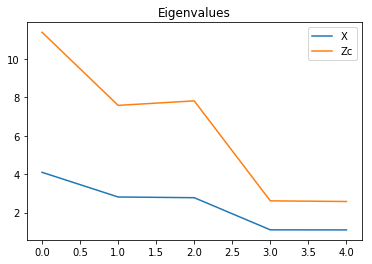

In [138]:
plt.figure()
plt.plot(np.diag(Lambda_X))
plt.plot(np.diag(Lambda_Zc))
plt.legend(['X', 'Zc'])
plt.title('Eigenvalues')

In [139]:
Lambda_Zc_inv = np.diag(1/np.diag(Lambda_Zc))
T_Zc = VT_Xc.T @ Lambda_Zc_inv @ Q_Zc.T
T_ZcR = Q_Zc @ Lambda_Zc @ VT_Xc
T_Yc = U_Xc.T @ R_inv_sqrt
T_YcR = R_sqrt @ U_Xc

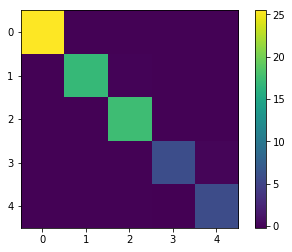

In [140]:
imshow(T_Yc @ H_Z @ T_ZcR)

In [141]:
S_Zc = np.diag(np.diag(T_Yc @ H_Z @ T_ZcR))

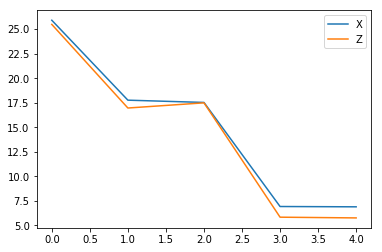

In [142]:
plt.figure()
plt.plot(np.diag(S_Xe))
plt.plot(np.diag(S_Zc))
plt.legend(['X', 'Z'])

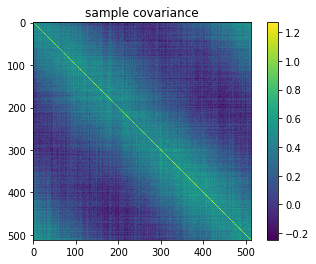

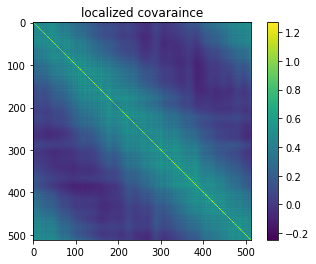

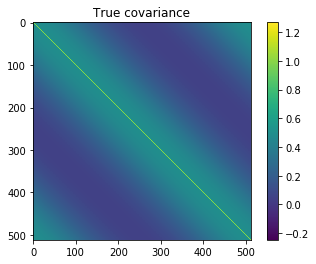

In [61]:
D_sqrt = np.diag(np.sqrt(np.diag(P_Z)))
P_Z_loc = D_sqrt @ C_Z_loc @ D_sqrt

vmin = np.min([P_Z_loc.min(),
               P.min(),
               P_Z.min()])
vmax = np.max([P_Z_loc.max(),
               P.max(),
               P_Z.max()])
imshow(P_Z, 'sample covariance',
       vmin=vmin, vmax=vmax)
imshow(P_Z_loc, 'localized covaraince',
       vmin=vmin, vmax=vmax)
imshow(P, 'True covariance',
       vmin=vmin, vmax=vmax)

In [1]:
plt.figure(dpi=300)
plt.plot(C_Z_ll[N_Z//2], '--')
plt.plot(C_Z[N_Z//2] , ':')
plt.plot(C_Z_loc[N_Z//2])
plt.plot(P[N_Z//2], alpha=0.5)
plt.plot(np.arange(N_Z)[::coarse],
         C_X[N_Z//(2 * coarse)], '-.')
plt.legend(['Parallel',
            'Z sample',
            'Localized',
            'True C',
            'X sample'])
plt.title('Correlations')

plt.figure(dpi=300)
plt.plot(P_Z[N_Z//2] , ':')
plt.plot(P_Z_loc[N_Z//2])
plt.plot(P[N_Z//2], alpha=0.5)
plt.plot(np.arange(N_Z)[::coarse],
         P_X[N_Z//(2 * coarse)], '-.')
plt.legend(['Z sample',
            'Localized',
            'True P',
            'X sample'])
plt.title('Covariances')

NameError: name 'plt' is not defined

In [19]:
# lam, Q = np.linalg.eigh(P_Z_loc)
lam, Q = np.linalg.eigh(P)
lam = lam[::-1]
Q = Q[:, ::-1]

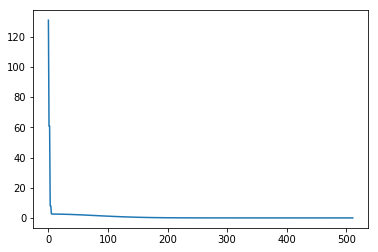

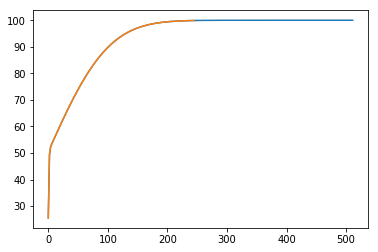

In [20]:
plt.figure()
plt.plot(lam)

lam_perc = lam.cumsum()/lam.sum() * 100
lam_tot = 99.9
lam_num = np.abs(lam_perc - lam_tot).argmin()

plt.figure()
plt.plot(lam_perc)
plt.plot(lam_perc[:lam_num])

Q = Q[:, :lam_num]
lam = lam[:lam_num]

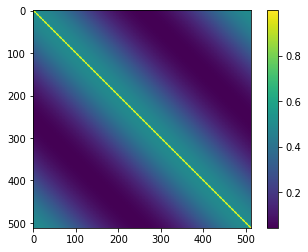

In [21]:
imshow(Q @ np.diag(lam) @ Q.T)

In [22]:
Tw = np.diag(lam**(-1/2)) @ Q.T
Twi = Q @ np.diag(lam**(1/2))

U, S, Vt = np.linalg.svd(H @ Twi)
S = np.diag(S)
S = np.concatenate([S, np.zeros([U.shape[0] - Vt.shape[0], Vt.shape[0]])], axis=0)

In [23]:
gt = np.random.multivariate_normal(np.zeros(N_z), P)
y = H @ gt + np.random.multivariate_normal(np.zeros(N_y), R)

In [24]:
Y = y[:, None] + np.random.multivariate_normal(np.zeros(N_y), R, N_eZ).T

In [25]:
Tz = Vt @ Tw
Ty = U.T @ (1/np.sqrt(R_var) * np.eye(N_y))

In [26]:
Zst = Tz @ (Z - Z.mean(axis=1)[:, None])
# Yst = Ty @ (Y - Y.mean(axis=1)[:, None])
Yst = Ty @ Y

In [27]:
K = S.T @ np.linalg.inv(S @ S.T + np.eye(S.shape[0]))

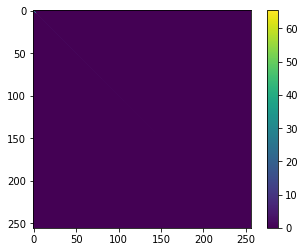

In [28]:
imshow(S @ S.T)

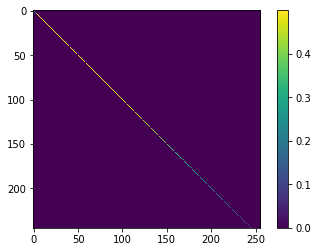

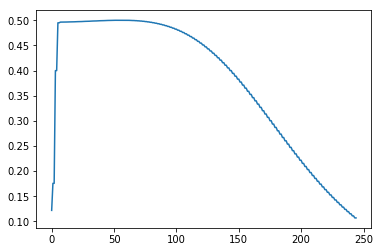

In [29]:
imshow(K)

plt.figure()
plt.plot(np.diag(K))

In [30]:
Zst_a = Zst + K @ (Yst - S @ Zst)

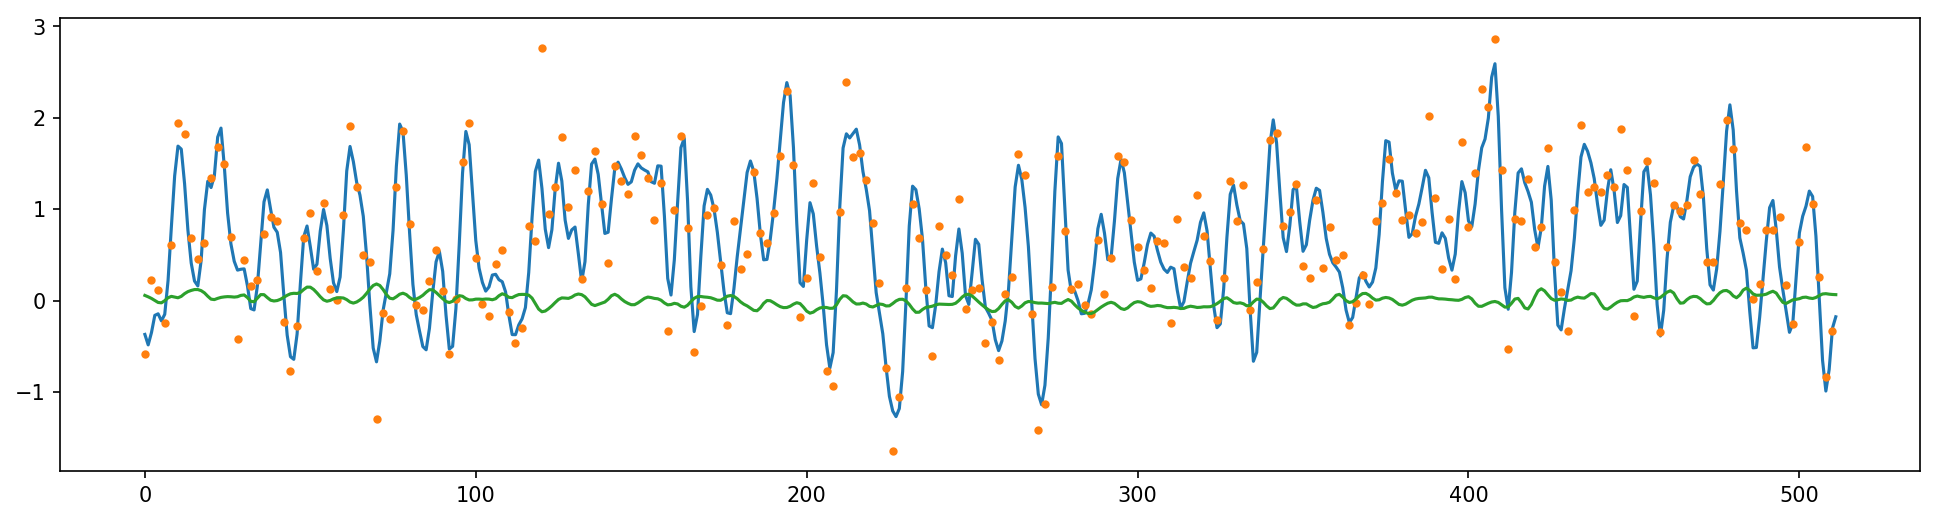

In [31]:
figsize = plt.figaspect(1/4)
plt.figure(dpi=150, figsize=figsize)
plt.plot(gt)
plt.plot(np.arange(N_z)[::every], y, '.')
plt.plot(Z.mean(axis=1))
# plt.plot(Z, 'k--', alpha=0.05)

In [32]:
Tzi = Twi @ Vt.T
Z_a = Tzi @ Zst_a + Z.mean(axis=1)[:, None]

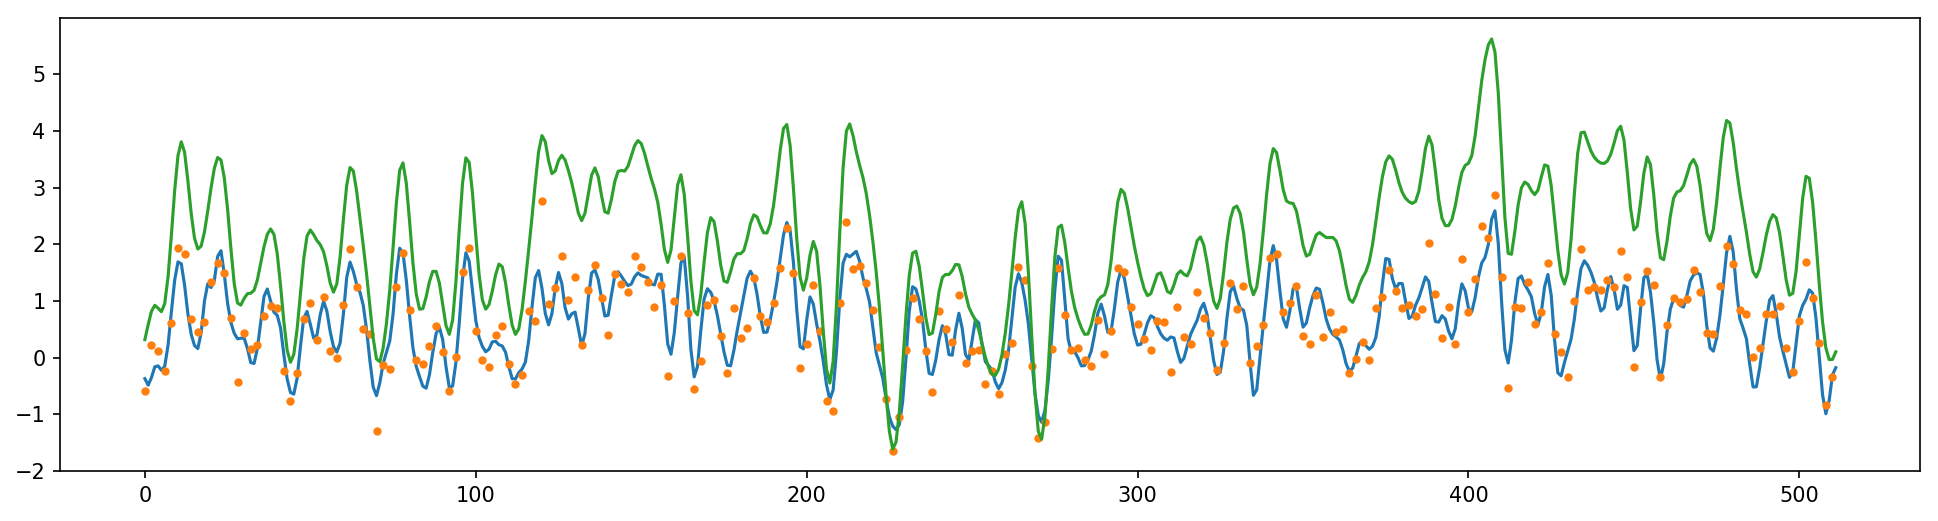

In [33]:
figsize = plt.figaspect(1/4)
plt.figure(dpi=150, figsize=figsize)
plt.plot(gt)
plt.plot(np.arange(N_z)[::every], y, '.')
plt.plot(Z_a.mean(axis=1))
# plt.plot(Z_a, 'k--', alpha=0.05)

In [34]:
K_old = P @ H.T @ np.linalg.inv(H @ P @ H.T  + R)

In [35]:
Z_a_old = Z  + K_old @ (Y - H @ Z)

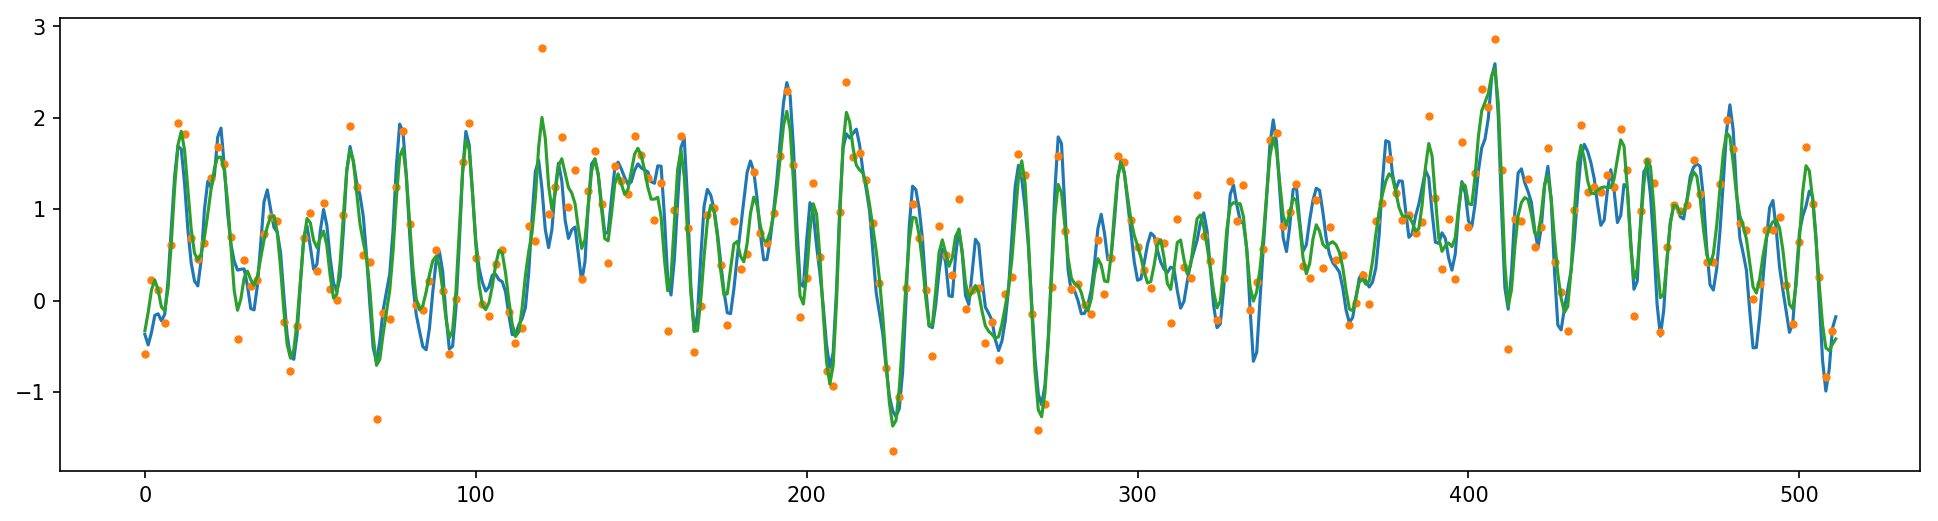

In [36]:
figsize = plt.figaspect(1/4)
plt.figure(dpi=150, figsize=figsize)
plt.plot(gt)
plt.plot(np.arange(N_z)[::every], y, '.')
plt.plot(Z_a_old.mean(axis=1))
# plt.plot(Z_a_old, 'k--', alpha=0.05)


In [37]:
def return_local(Z, X, coarse):
    X_cor = X - X.mean(axis=1)[:, None]
    sd_X = np.sqrt((X_cor**2).sum(axis=1)/(N_eXc - 1))
    X_cor = X_cor / sd_X[:, None]
    Q, delta, temp = np.linalg.svd(X_cor/np.sqrt(N_eXc - 1))

    this_sig_num = 5
    Q_interp = utilities.upscale_on_loop(Q[:, :this_sig_num].T, coarse).T
    Q_interp, temp = np.linalg.qr(Q_interp)
    delta_interp = delta[:this_sig_num]

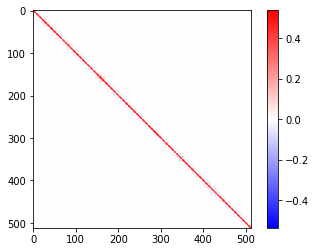

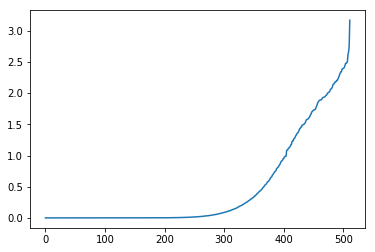

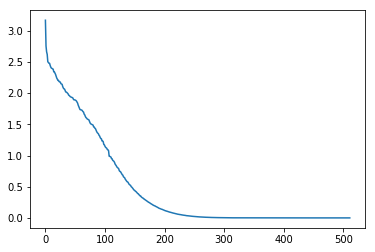

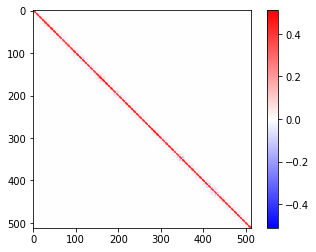

In [38]:
s_o, U_o = np.linalg.eigh(C_Z_orth_loc)

recon = U_o @ np.diag(s_o) @ U_o.T
vmax = np.abs(recon).max()
imshow(recon,
       vmax=vmax, vmin=-vmax, cmap='bwr')


ind_sort = np.argsort(np.abs(s_o))[::-1]
s_os = s_o[ind_sort]
U_os = U_o[:, ind_sort]

plt.figure()
plt.plot(s_o)


plt.figure()
plt.plot(s_os)

sig_num = 150
# U_os[]
low_recon = U_os[:, :sig_num] @ np.diag(s_os[:sig_num]) @ U_os[:, :sig_num].T
vmax = np.abs(low_recon).max()
imshow(low_recon,
       vmax=vmax, vmin=-vmax, cmap='bwr')

In [39]:
U_o.shape

(512, 512)

In [40]:
s_o.shape

(512,)

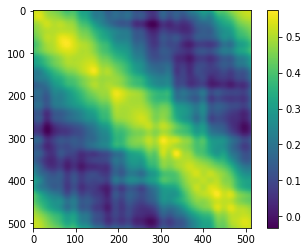

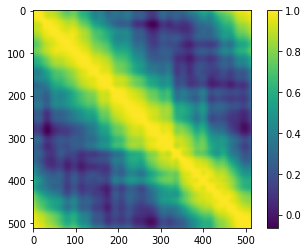

In [41]:
imshow(Q_interp @ np.diag(szll) @ Q_interp.T)
D_inv_sqrt = np.diag(1/np.sqrt(np.diag(Q_interp @ np.diag(szll) @ Q_interp.T)))
imshow(D_inv_sqrt @ Q_interp @ np.diag(szll) @ Q_interp.T @ D_inv_sqrt)

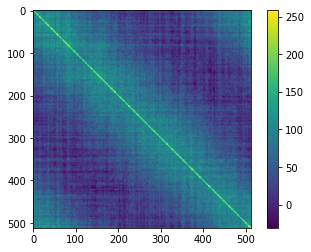

In [42]:
imshow(Z @ Z.T)

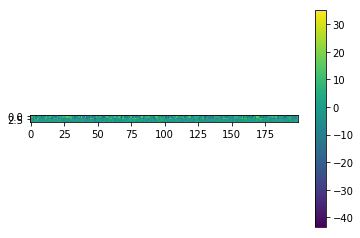

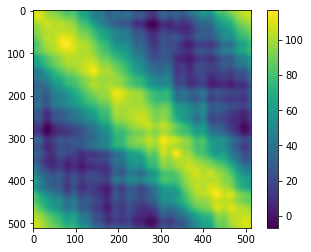

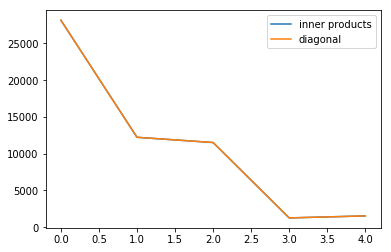

In [43]:
this = Q_interp.T @ Z
imshow(this)

imshow(Q_interp @ np.diag(np.diag(this @ this.T)) @ Q_interp.T)


plt.figure()
plt.plot((this**2).sum(axis=1))
plt.plot(np.diag(this @ this.T))
plt.legend(['inner products', 'diagonal'])

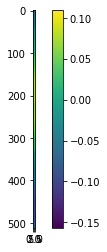

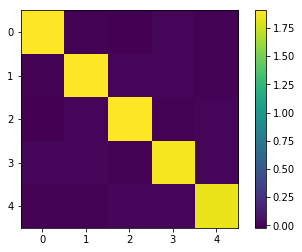

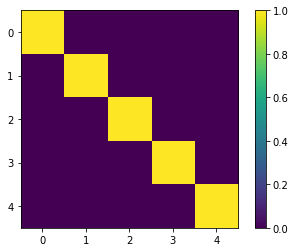

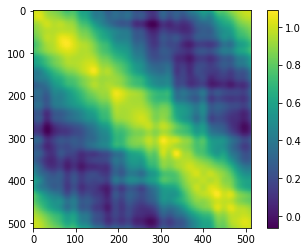

In [44]:
this = D_inv_sqrt @ Q_interp
imshow(this)
imshow(this.T @ this)
imshow(Q_interp.T @ Q_interp)
this_D = np.diag(np.sqrt(np.diag(this.T @ this)))
imshow(Q_interp @ this_D @ np.diag(szll) @ this_D @ Q_interp.T)

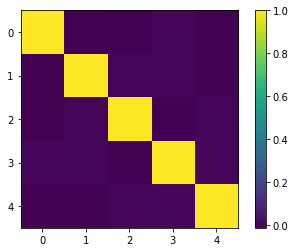

In [45]:
that = this / np.linalg.norm(this, axis=0)[None, :]
imshow(that.T @ that)

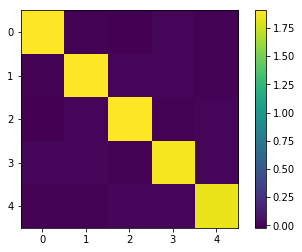

In [46]:
imshow(Q_interp.T @ D_inv_sqrt @ D_inv_sqrt @ Q_interp)

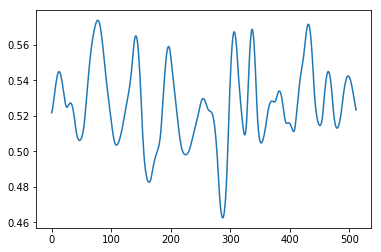

In [47]:
plt.figure()
plt.plot(np.diag(C_Z_ll))

In [48]:
# # Uz, sz, VTz = np.linalg.svd(P_Z_orth_loc)
# sz, Uz = np.linalg.eigh(P_Z_orth_loc)

# plt.figure()
# plt.plot(sz)

# sig_per = 99.9

# sz_per = sz.cumsum()/sz.sum() * 100
# sig_indz = np.abs(sz_per - sig_per).argmin()


# plt.figure()
# plt.plot(sz_per)
# plt.scatter(sig_indz, sz_per[sig_indz])

# plt.figure()
# plt.plot(sz)
# plt.plot(sig_indz, sz[sig_indz], marker='o')

# plt.figure()
# plt.semilogy(sz)
# plt.semilogy(sig_indz, sz[sig_indz], marker='o')

# imshow(Uz[:, :sig_indz] @ np.diag(sz[:sig_indz]) @ VTz[:sig_indz])

In [49]:
# imshow(Uz[:, :sig_indz] @ np.diag(sz[:sig_indz]) @ VTz[:sig_indz])

In [50]:
ens_size = int(1e3)
mu = np.zeros(dimension)

X = (
    assimilate.generate_ensemble(
        ens_size, mu, P_sqrt))

In [51]:
Ux, sx, VTx = np.linalg.svd((X - X.mean(axis=1)[:, None])/np.sqrt(ens_size - 1))

Ux = Ux[:, :sx.size]

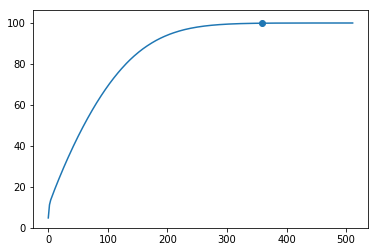

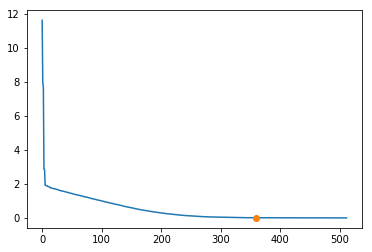

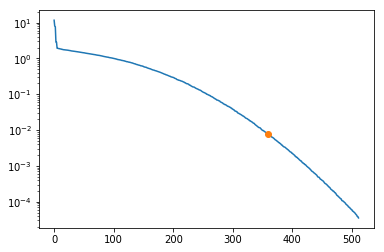

In [52]:
sig_per = 99.9

sx_per = sx.cumsum()/sx.sum() * 100
sig_ind = np.abs(sx_per - sig_per).argmin()


plt.figure()
plt.plot(sx_per)
plt.scatter(sig_ind, sx_per[sig_ind])

plt.figure()
plt.plot(sx)
plt.plot(sig_ind, sx[sig_ind], marker='o')

plt.figure()
plt.semilogy(sx)
plt.semilogy(sig_ind, sx[sig_ind], marker='o')

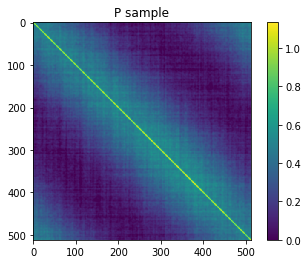

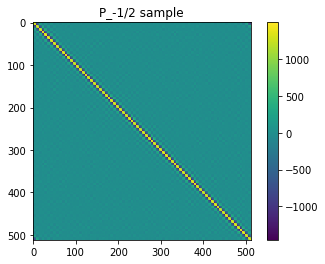

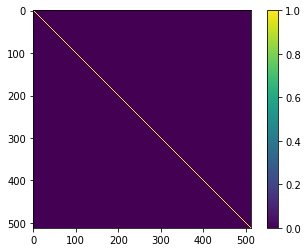

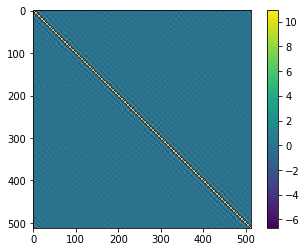

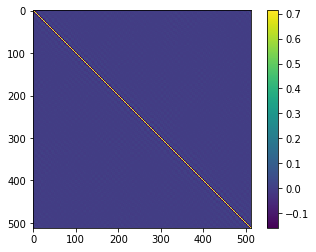

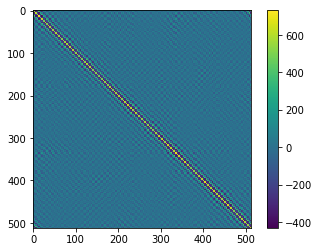

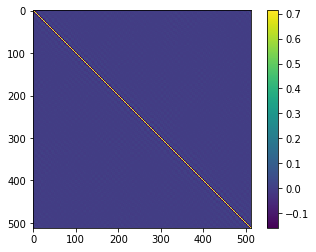

In [53]:
P_sample = Ux @ np.diag(sx**2) @ Ux.T
imshow(P_sample, vmin=0, title='P sample')

P_sample_inv_sqrt = Ux @ np.diag(1/sx) @ Ux.T
imshow(P_sample_inv_sqrt, title='P_-1/2 sample')

imshow(P_sample_inv_sqrt @ P_sample @ P_sample_inv_sqrt.T)


P_red_sample = Ux[:, :sig_ind] @ np.diag(sx[:sig_ind]**2) @ Ux[:, :sig_ind].T
P_red_inv_sqrt = Ux[:, :sig_ind] @ np.diag(1/sx[:sig_ind]) @ Ux[:, :sig_ind].T
P_red_inv = Ux[:, :sig_ind] @ np.diag(1/sx[:sig_ind]**2) @ Ux[:, :sig_ind].T
imshow(P_red_inv_sqrt)
imshow(P_red_inv_sqrt @ P_red_sample @ P_red_inv_sqrt)

imshow(P_red_inv)
imshow(P_red_inv @ P_red_sample)

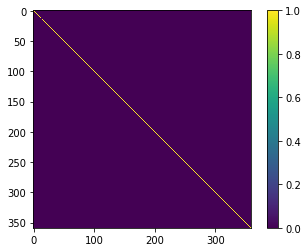

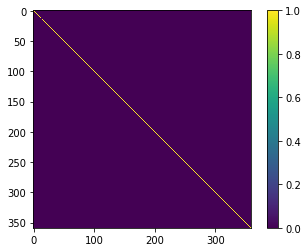

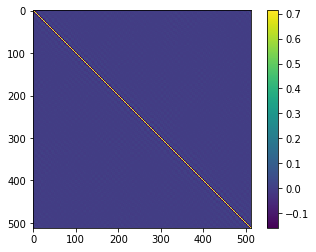

In [54]:
Tw = np.diag(1/sx[:sig_ind]) @ Ux[:, :sig_ind].T 
Twi = Ux[:, :sig_ind] @ np.diag(sx[:sig_ind])
imshow(Tw @ P_sample @ Tw.T)

imshow(Tw @ Twi)

imshow(Twi @ Tw)